1) Make Data for classification

In [3]:
import sklearn
from sklearn.datasets import make_circles

In [4]:
n_samples = 1000

X,y = make_circles(n_samples, noise= 0.03,random_state = 42 )

len(X), len(y)


(1000, 1000)

In [5]:
#make a DataFrame
import pandas as pd
circles = pd.DataFrame({'x1': X[ :,0],
                         'x2' : X[: ,1],
                         'label' : y})
circles.head()

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


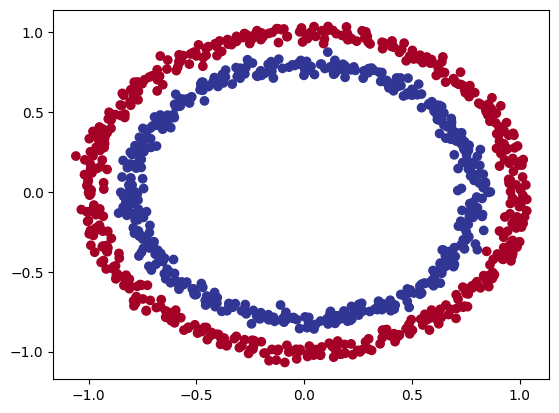

In [6]:
#visualize
import matplotlib.pyplot as plt
plt.scatter(x= X[ :,0]
            ,y = X[: ,1]
            ,c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
type(X),type(y)

(numpy.ndarray, numpy.ndarray)

In [8]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)




In [9]:
X[:5] , y[: 5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
torch.manual_seed(42)

In [11]:
#train and test spilit
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(X,
                                                        y,
                                                        test_size= 0.2,
                                                        random_state=42)

len(X_train), len(X_test), len(y_train) , len(y_test)

(800, 200, 800, 200)

In [12]:
# 2) build a model
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [13]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

In [14]:
#tarif class

class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,out_features=5)
    self.layer_2 = nn.Linear(in_features=5,out_features=1)


  #define a forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # x -> layer 1 -> layer 2 -> output

#tarif class

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
next(model_0.parameters()).device

device(type='cpu')

In [16]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
#setup loss func

loss = nn.BCEWithLogitsLoss() #built-in activation function (sigmiod)

#optimizer
op = torch.optim.SGD(params=model_0.parameters(),
                     lr= 0.1)

In [18]:
#calcuate accuracy
def acc_fun(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc


In [19]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [20]:
y_pred_pro = torch.sigmoid(y_logits)
y_pred_pro

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [21]:
y_prods = torch.round(y_pred_pro)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))[:5]

print(torch.eq(y_prods.squeeze(), y_pred_labels.squeeze()))

y_prods.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [22]:
torch.manual_seed(42)

epochs = 900

#put data to the device
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

for epoch in range(epochs):
  #train

  model_0.train()

  # 1) forward pass

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2) loss func

  ls = loss(y_logits,y_train)
  acc = acc_fun(y_true= y_train , y_pred= y_pred)

  # 3) zero grad

  op.zero_grad()

  # 4) backpro
  ls.backward()

  # 5) optim

  op.step()


  # Testing

  model_0.eval()
  with torch.inference_mode():

    # 1) forward pass

    y_logits_test = model_0(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logits_test))


    # 2) test loss

    ls_tst = loss(y_logits_test,y_test)
    acc_test = acc_fun(y_true= y_test , y_pred= y_pred_test)

  if epoch % 10 == 0:
    print(f'epoch : {epoch} | loss : {ls:.5f} | acc: {acc:.2f} | test_loss : { ls_tst:.5}| acc_test : {acc_test: .2f}')

epoch : 0 | loss : 0.69796 | acc: 51.88 | test_loss : 0.6944| acc_test :  58.00
epoch : 10 | loss : 0.69590 | acc: 51.25 | test_loss : 0.69305| acc_test :  53.00
epoch : 20 | loss : 0.69490 | acc: 51.62 | test_loss : 0.69254| acc_test :  49.50
epoch : 30 | loss : 0.69435 | acc: 51.12 | test_loss : 0.69236| acc_test :  49.50
epoch : 40 | loss : 0.69401 | acc: 50.88 | test_loss : 0.69232| acc_test :  51.00
epoch : 50 | loss : 0.69378 | acc: 50.25 | test_loss : 0.69234| acc_test :  50.00
epoch : 60 | loss : 0.69362 | acc: 50.00 | test_loss : 0.69239| acc_test :  51.50
epoch : 70 | loss : 0.69351 | acc: 50.25 | test_loss : 0.69246| acc_test :  51.00
epoch : 80 | loss : 0.69342 | acc: 49.88 | test_loss : 0.69254| acc_test :  50.00
epoch : 90 | loss : 0.69336 | acc: 49.88 | test_loss : 0.69262| acc_test :  53.00
epoch : 100 | loss : 0.69331 | acc: 49.25 | test_loss : 0.69271| acc_test :  53.00
epoch : 110 | loss : 0.69327 | acc: 49.75 | test_loss : 0.69279| acc_test :  54.00
epoch : 120 | lo

In [23]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

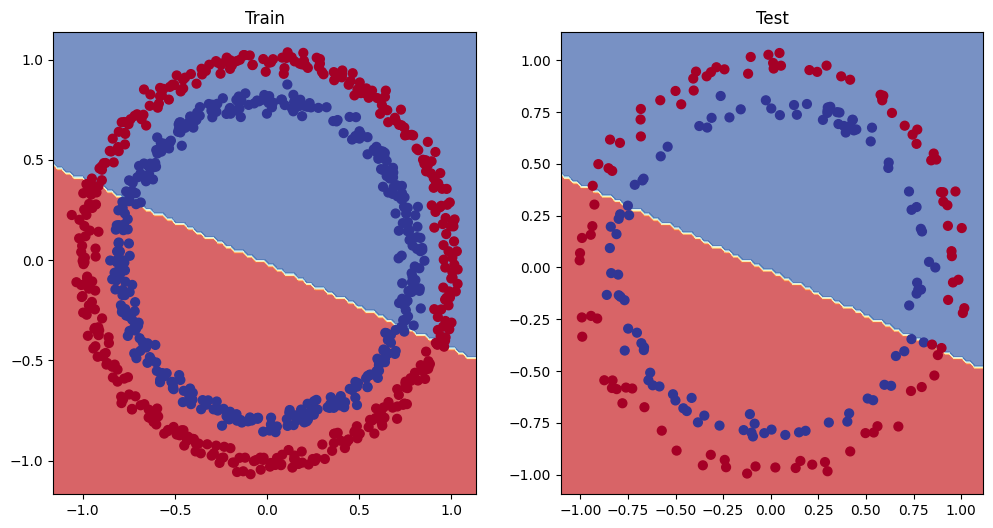

In [24]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [25]:
# Improve model

class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
#create loss func

loss = nn.BCEWithLogitsLoss()

#optimizer

op = torch.optim.SGD(params=model_1.parameters(),lr=0.01)

In [27]:
#training loop

torch.manual_seed(42)

#put data to the device
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  # step 0

  model_1.train()

  #step 1

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #step 2

  ls = loss(y_logits,y_train)
  acc = acc_fun(y_true= y_train , y_pred= y_pred)

  #step 3

  op.zero_grad()

  #step 4

  ls.backward()

  #step 5

  op.step()



  #testing

  model_1.eval()
  with torch.inference_mode():

    #step 1
    y_logit_test = model_1(X_test).squeeze()
    y_pred_test = torch.round(torch.sigmoid(y_logit_test))

    #step 2

    ls_test = loss(y_logit_test,y_test)
    acc_test = acc_fun(y_true= y_test , y_pred= y_pred_test)

  if epoch % 100 == 0:
    print(f'epoch : {epoch} | loss : {ls:.5f} | acc: {acc:.2f} | test_loss : { ls_tst:.5}| acc_test : {acc_test: .2f}')

epoch : 0 | loss : 0.69396 | acc: 50.88 | test_loss : 0.69457| acc_test :  51.00
epoch : 100 | loss : 0.69369 | acc: 50.25 | test_loss : 0.69457| acc_test :  50.00
epoch : 200 | loss : 0.69351 | acc: 50.12 | test_loss : 0.69457| acc_test :  49.50
epoch : 300 | loss : 0.69339 | acc: 50.50 | test_loss : 0.69457| acc_test :  49.00
epoch : 400 | loss : 0.69329 | acc: 50.38 | test_loss : 0.69457| acc_test :  48.50
epoch : 500 | loss : 0.69322 | acc: 49.88 | test_loss : 0.69457| acc_test :  49.50
epoch : 600 | loss : 0.69317 | acc: 49.50 | test_loss : 0.69457| acc_test :  53.00
epoch : 700 | loss : 0.69313 | acc: 49.38 | test_loss : 0.69457| acc_test :  50.50
epoch : 800 | loss : 0.69309 | acc: 50.00 | test_loss : 0.69457| acc_test :  51.00
epoch : 900 | loss : 0.69307 | acc: 50.62 | test_loss : 0.69457| acc_test :  47.50


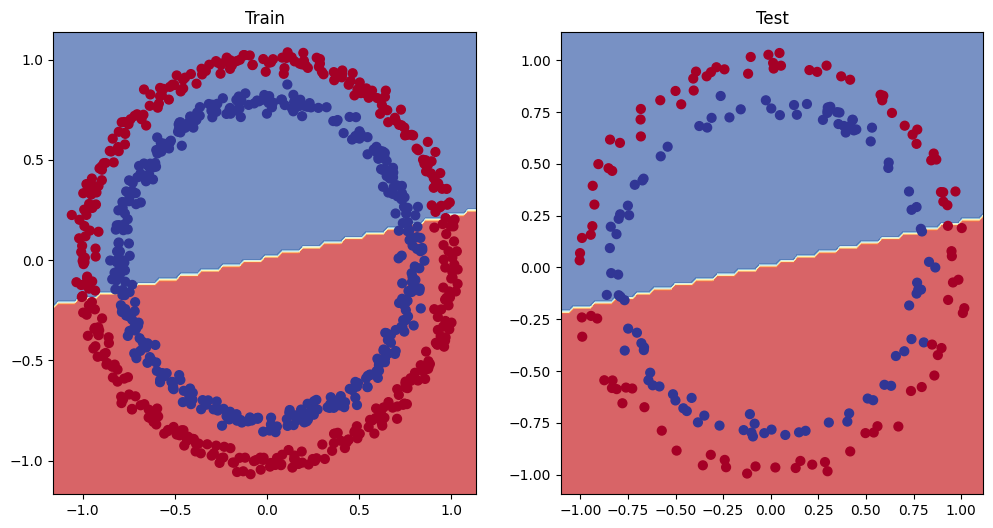

In [28]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [29]:
weight = 0.7
bias = 0.3

#create
start = 0
end = 1
step = 0.01
X_reg=  torch.arange(start,end,step).unsqueeze(dim=1)
y_reg = weight * X_reg + bias
X_reg[:10], y_reg[:10]
len(X_reg) , len(y_reg)

(100, 100)

In [30]:
#train and test spilit
train_spilit =  int(0.8 * len(X_reg))
X_train_reg, y_train_reg = X_reg[:train_spilit], y_reg[:train_spilit]
X_test_reg, y_test_reg = X_reg[train_spilit:], y_reg[train_spilit:]
len(X_train_reg),len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

In [31]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1,out_features=10),
    nn.Linear(in_features=10,out_features=10),
    nn.Linear(in_features=10,out_features=1),
)
model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
#create loss and opt

loss = nn.L1Loss()

#op
op = torch.optim.SGD(params = model_2.parameters(),lr=0.1)

In [33]:
#training

torch.manual_seed(42)

X_train_reg , y_train_reg = X_train_reg.to(device) , y_train_reg.to(device)
X_test_reg , y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

epochs = 900

for epoch in range(epochs):
   # 0
   model_2.train()

   # 1
   y_pred_reg = model_2(X_train_reg)

   # 2
   ls = loss(y_pred_reg,y_train_reg)

   # 3
   op.zero_grad()

   # 4
   ls.backward()

   # 5
   op.step()


   #testing

   model_2.eval()
   with torch.inference_mode():

    # 1
    test_y_reg = model_2(X_test_reg)

    # 2
    ls_test_reg = loss(test_y_reg,y_test_reg)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {ls:.5f}, Test loss: {ls_test_reg:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425


**Non**-**linearity**

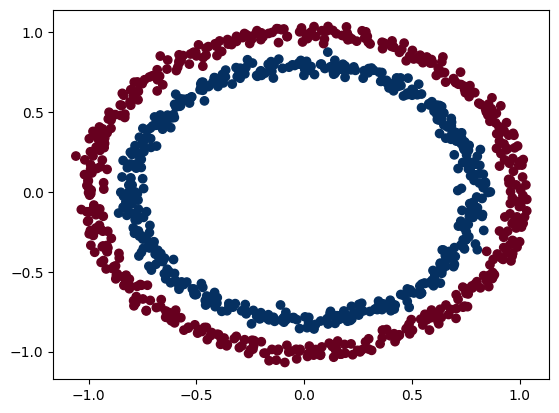

In [34]:
import sklearn
from sklearn.datasets import make_circles

n_sample = 1000

X , y = make_circles(n_samples,
                     noise=0.03,
                     random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [35]:
#train into tensor and then spilit to train and test

import torch
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state = 42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

In [36]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer_1 = nn.Linear(in_features=2,out_features=10)
    self.layer_2 = nn.Linear(in_features=10,out_features=10)
    self.layer_3 = nn.Linear(in_features=10,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return(self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x))))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [37]:
#start up loss fun and op

loss = nn.BCEWithLogitsLoss()

#op

op= torch.optim.SGD(params=model_3.parameters(),lr=0.1)

In [38]:
#training

torch.manual_seed(42)

#put data to device
X_train , y_train = X_train.to(device) , y_train.to(device)
X_test , y_test = X_test.to(device) , y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  # 0

  model_3.train()

  #1

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2

  ls = loss(y_logits ,y_train)
  acc = acc_fun(y_true=y_train,y_pred=y_pred)

  #3

  op.zero_grad()

  #4

  ls.backward()

  #5

  op.step()


  #testing

  model_3.eval()
  with torch.inference_mode():

    #1
    test__logit_pred = model_3(X_test).squeeze()
    test_logits = torch.round(torch.sigmoid(test__logit_pred))

    #2
    ls_test = loss(test_logits,y_test)
    acc_test = acc_fun(y_true=y_test,y_pred=test_logits)


  if epoch % 100 == 0:
    print(f'epoch : {epoch} | loss : {ls:.5f} | acc: {acc:.2f} | test_loss : { ls_tst:.5}| acc_test : {acc_test: .2f}')

epoch : 0 | loss : 0.69295 | acc: 50.00 | test_loss : 0.69457| acc_test :  50.00
epoch : 100 | loss : 0.69115 | acc: 52.88 | test_loss : 0.69457| acc_test :  52.50
epoch : 200 | loss : 0.68977 | acc: 53.37 | test_loss : 0.69457| acc_test :  55.00
epoch : 300 | loss : 0.68795 | acc: 53.00 | test_loss : 0.69457| acc_test :  56.00
epoch : 400 | loss : 0.68517 | acc: 52.75 | test_loss : 0.69457| acc_test :  56.50
epoch : 500 | loss : 0.68102 | acc: 52.75 | test_loss : 0.69457| acc_test :  56.50
epoch : 600 | loss : 0.67515 | acc: 54.50 | test_loss : 0.69457| acc_test :  56.00
epoch : 700 | loss : 0.66659 | acc: 58.38 | test_loss : 0.69457| acc_test :  59.00
epoch : 800 | loss : 0.65160 | acc: 64.00 | test_loss : 0.69457| acc_test :  67.50
epoch : 900 | loss : 0.62362 | acc: 74.00 | test_loss : 0.69457| acc_test :  79.00


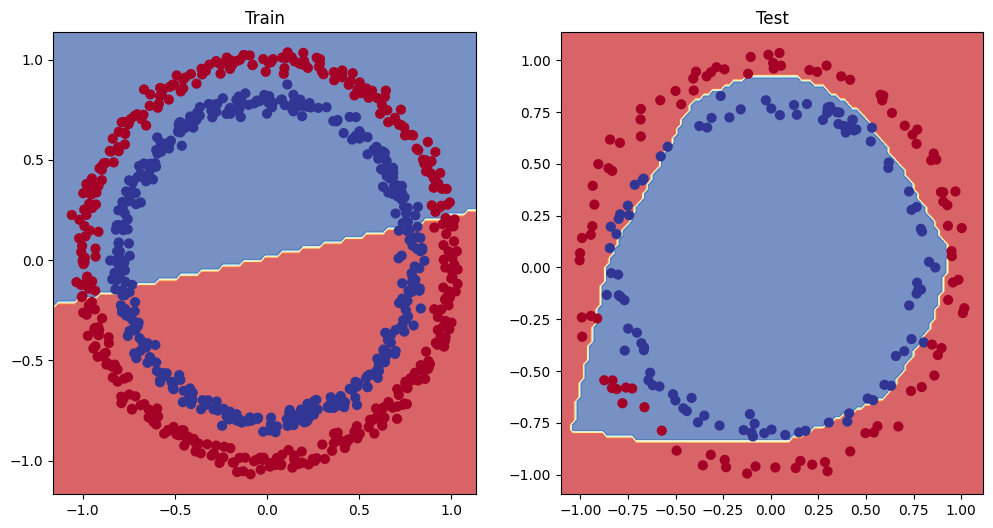

In [39]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

**Multiclass classification**

In [40]:
import torch
from torch import nn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

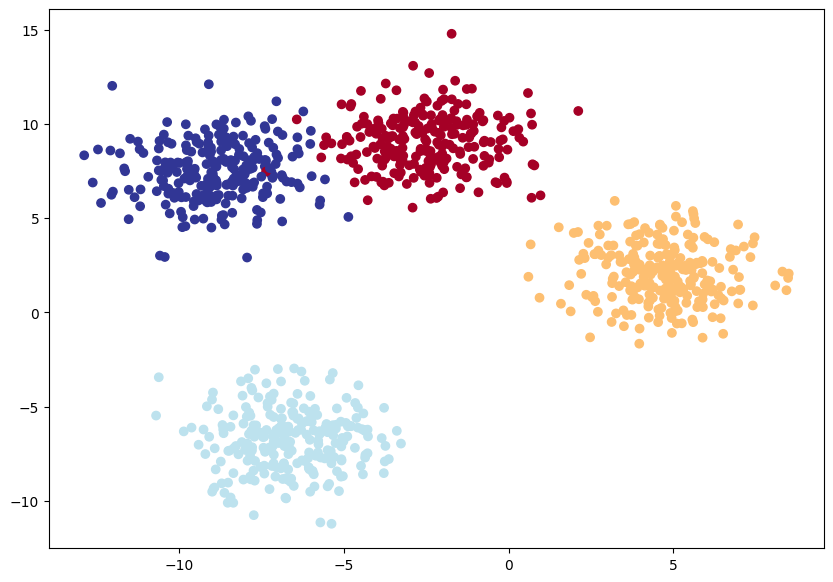

In [41]:
#data

RANDOM_SEED=42
NUM_CLASSES = 4
NUM_FEATURES = 2

X_blob , y_blob = make_blobs(n_samples=1000,
                             n_features=NUM_FEATURES,
                             centers = NUM_CLASSES,
                             cluster_std= 1.5,
                             random_state= RANDOM_SEED
                             )

# turn into tensor
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)


#train_teest

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)


# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);



In [42]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [43]:
class BlobModel(nn.Module):
  def __init__(self,input_features , output_features , hidden_units=8):

    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features , out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units , out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units , out_features=output_features),

    )

  def forward(self,x):
    return self.linear_layer_stack(x)

model_4 = BlobModel(input_features=2, output_features=4, hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [44]:
#create loss func and op

loss = nn.CrossEntropyLoss()

#op
op = torch.optim.SGD(params = model_4.parameters(),lr=0.1)

In [45]:
#training loop

torch.manual_seed(42)


# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)


epochs = 100
for epoch in range(epochs):
  model_4.train()

  #1
  y_logits = model_4(X_blob_train)
  y_pred_blb = torch.softmax(y_logits,dim=1).argmax(dim=1)

  #2
  ls = loss(y_logits,y_blob_train)
  acc = acc_fun(y_true = y_blob_train, y_pred = y_pred_blb)

  #3
  op.zero_grad()

  #4
  ls.backward()

  #5
  op.step()


  #testing

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)

    test_preds = torch.softmax(test_logits,dim=1).argmax(dim=1)

    ls_test = loss(test_logits,y_blob_test)
    ac_test = acc_fun(y_true = y_blob_test, y_pred = test_preds)


   # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {ls:.5f}, Acc: {acc:.2f}% | Test Loss: {ls_test:.5f}, Test Acc: {ac_test:.2f}%")


Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


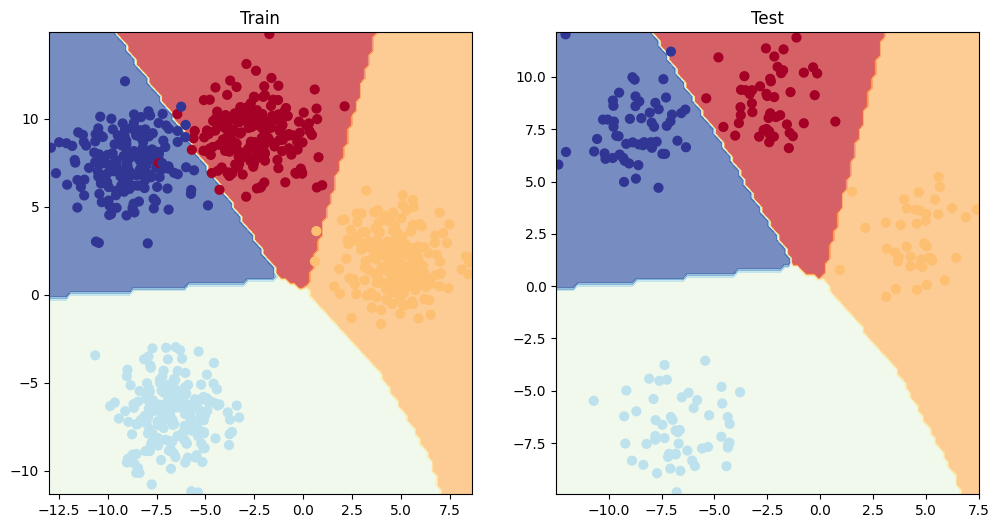

In [46]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)


In [49]:
!pip install torchmetrics



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 51.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [50]:
import torchmetrics

In [52]:
from torchmetrics import Accuracy

In [59]:
acc = Accuracy(task="multiclass",num_classes=4).to(device)

acc(y_pred_blb,y_blob_train)

tensor(0.9925)